In [1]:
# https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-DATASET
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Found Gpu" if torch.cuda.is_available() else "No Gpu")

No Gpu


In [3]:
# Load the CSV files into pandas DataFrames
data = pd.read_csv("merged.csv")

In [4]:

# Print the first 5 rows of the DataFrame
data.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [5]:
# Define the model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(21, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 256)
        self.fc3 = nn.Linear(256, 1024)
        self.batchnorm = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(0.50)
        self.fc6 = nn.Linear(256, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x

In [6]:
# Scale and process the data
scaler = StandardScaler()
# X = data.drop('Diabetes_binary', axis=1)
df = data
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
X = scaled_df.drop("Diabetes_binary", axis=1)
Y = data["Diabetes_binary"]
del df, scaled_data, scaled_df

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=3, stratify=Y, shuffle=True
)

In [8]:
# Print the shapes of the train and test sets
print("Shape of the X_train {}".format(X_train.shape))
print("Shape of the y_train {}".format(y_train.shape))
print("Shape of the X_test {}".format(X_test.shape))
print("Shape of the y_test {}".format(y_test.shape))

Shape of the X_train (56553, 21)
Shape of the y_train (56553,)
Shape of the X_test (14139, 21)
Shape of the y_test (14139,)


In [9]:
# Convert the train and test sets into numpy arrays
X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()
X_test_array = X_test.to_numpy()
y_test_array = y_test.to_numpy()
# Convert the numpy arrays into PyTorch tensors
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long).to(device)
#del X_train_array, y_train_array, X_test_array, y_test_array

In [10]:
# Define the model, optimizer and loss function
losses = list()
model = SimpleModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
batch_size = 32

2023-11-09 11:07:22.805847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 11:07:25.734634: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
def plot_it():
    """
    Plot the training loss over epochs
    """
    print(losses)
    plt.plot(np.arange(len(losses)) + 1, losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

In [12]:
# Train the model
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
temp = list()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    temp.clear()
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        temp.append(loss.item())
    losses.append(np.mean(temp))
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")
    plot_it()
    if epoch % 5 == 0:
        torch.save(model, f"model{epoch // 5}.pt")

Epoch 1/30:  27%|██▋       | 486/1768 [00:02<00:07, 179.24it/s]


KeyboardInterrupt: 

[]


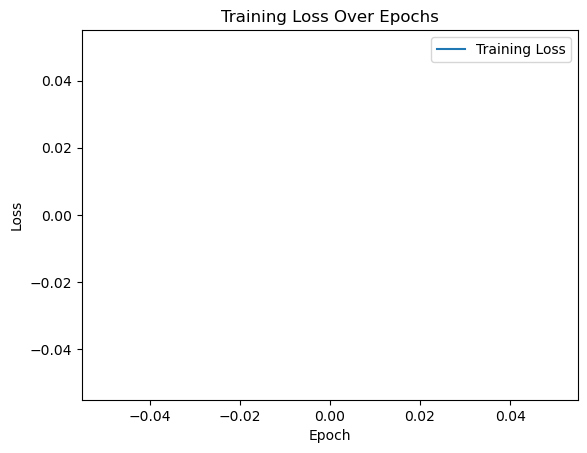

Test Accuracy: 0.7478


In [13]:
# Plot the training loss over epochs
plot_it()
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted_labels = np.argmax(outputs.cpu(), axis=1)
    accuracy = np.mean(predicted_labels.numpy() == y_test.to_numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Save the model
torch.save(model, "model.pt")

In [16]:
model = torch.load("model3.pt", map_location=torch.device('cpu'))

In [15]:
# test the model
dict1 = {}
for i in range(16):
    model = torch.load(f"model{i}.pt")
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predicted_labels = np.argmax(outputs.cpu(), axis=1)
        accuracy = np.mean(predicted_labels.numpy() == y_test.to_numpy())
        print(f"Test Accuracy{i}: {accuracy:.4f}")
        dict1[f"model{i}.pt"] = f"{accuracy:.4f}"

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [17]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted_labels = np.argmax(outputs.cpu(), axis=1)
    accuracy = np.mean(predicted_labels.numpy() == y_test.to_numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7522


In [16]:
from Get_data import get_user_input  # custom function to get user input

user_input = get_user_input()
print("User Input:")
backup = user_input
print(user_input)
user_input = scaler.fit_transform(user_input.reshape(-1, 1))
user_input = torch.tensor([user_input], dtype=torch.float32).to(device)
out = model(user_input)
temp = out[0][0] - out[0][1]
temp = str(temp).split(',')[0].split('(')[1]
if out[0][0] > out[0][1]:
    print("You don't have diabetes probability: ", (1 - float(temp)) * 100)
else:
    print("You have diabetes probability: ", float(temp))

User Input:
[ 1  1  1 26  0  0  0  1  1  1  0  1  0  3 30  3  0  1  0  6  8]


/tmp/ipykernel_1921/3512270828.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/torch/csrc/utils/tensor_new.cpp:261.)
  user_input = torch.tensor([user_input], dtype=torch.float32).to(device)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (21x1 and 21x64)

In [40]:
user_input = [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 3, 1, 3, 0, 1, 0, 6, 8]
user_input = torch.tensor([user_input], dtype=torch.float32).to(device)
out = model(user_input)
temp = out[0][0] - out[0][1]
temp = str(temp).split(',')[0].split('(')[1]
print(out)
if out[0][0] > out[0][1]:
    print("You don't have diabetes probability: ", (1 - float(temp)) * 100)
else:
    print("You have diabetes probability: ",  abs(float(temp)))

tensor([[0.9822, 0.0178]], grad_fn=<SoftmaxBackward0>)
You don't have diabetes probability:  3.5599999999999965


In [ ]:
user_input = backup
user_input = torch.tensor(np.array([user_input], dtype=np.float32), dtype=torch.float32).to(device)
model(user_input)

In [ ]:
user_input = backup
#user_input = scaler.fit_transform(user_input.reshape(-1, 1))
#user_input = np.transpose(user_input)[0]
user_input = torch.tensor([user_input], dtype=torch.float32).to(device)
out = model(user_input)
if out[0][0] > out[0][1]:
    print("You don't have diabetes")
else:
    print("You have diabetes")

In [ ]:
user_input = [1, 1, 1, 30, 0, 0, 0, 1, 1, 1, 0, 1, 0, 3, 30, 0, 0, 1, 1, 4, 1]

In [ ]:
user_input = [1, 1, 1, 30, 0, 0, 0, 1, 1, 1, 0, 1, 0, 3, 30, 0, 0, 1, 1, 4, 1]
user_input = np.array(user_input)
user_input = torch.tensor(
    scaler.fit_transform(pd.DataFrame([user_input], columns=X.columns))
).to(device)

In [ ]:
backup = np.array(user_input, dtype=np.float32)

In [ ]:
backup = [1, 1, 1, 30, 0, 0, 0, 1, 1, 1, 0, 1, 0, 3, 30, 0, 0, 1, 1, 4, 1]

In [ ]:
out

In [ ]:
print(data)

In [ ]:
import hiddenlayer as hl

model = model.to('cpu')
print(model.parameters)